In [1]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def draw_sample(image, mask, classes):

    gray_mask = []

    for line in sample["mask"]:
        for pix in line:
            gray_mask.append(classes[np.argmax(pix)])

    gray_mask = np.reshape(gray_mask, (mask.shape[0], mask.shape[1]))
    print("classes: {}".format(np.unique(gray_mask)))

    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image")

    plt.subplot(1, 2, 2)
    plt.imshow(gray_mask, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Mask")

In [3]:
ROOT = Path("")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"

In [4]:
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

In [5]:
from typing import List
from catalyst import utils

from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(
        self,
        classes,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms
        self.n_classes = len(classes)
        self.classes = classes

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        result = {"image": image}

        if self.masks is not None:
            mask = cv2.imread(str(self.masks[idx]),0)
            one_hot = np.zeros((mask.shape[0], mask.shape[1], self.n_classes))
            for i, unique_value in enumerate(self.classes):
                one_hot[:, :, i][mask == unique_value] = 1
            result["mask"] = one_hot

        if self.transforms is not None:
            result = self.transforms(**result)

        result["filename"] = image_path.name

        return result

classes: [  0  29  76 105 128 149 178 225 255]
[[[237 243 243]
  [237 243 243]
  [237 243 243]
  ...
  [234 240 240]
  [234 240 240]
  [233 239 239]]

 [[237 243 243]
  [237 243 243]
  [237 243 243]
  ...
  [234 240 240]
  [233 239 239]
  [233 239 239]]

 [[237 243 243]
  [237 243 243]
  [237 243 243]
  ...
  [234 240 240]
  [233 239 239]
  [233 239 239]]

 ...

 [[ 19  25  25]
  [ 19  25  25]
  [ 18  24  24]
  ...
  [ 32  41  38]
  [ 28  37  36]
  [ 26  36  35]]

 [[ 19  25  25]
  [ 19  25  25]
  [ 19  25  25]
  ...
  [ 28  37  34]
  [ 25  34  33]
  [ 25  35  34]]

 [[ 20  26  26]
  [ 19  25  25]
  [ 19  25  25]
  ...
  [ 26  35  32]
  [ 23  32  31]
  [ 23  33  32]]] (342, 256, 9)


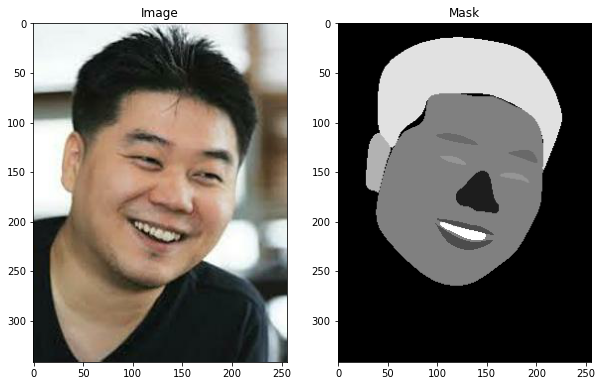

In [6]:
CLASSES = [0, 29, 76, 105, 128, 149, 178, 225, 255]
dataset = SegmentationDataset(CLASSES, ALL_IMAGES, ALL_MASKS)
#
sample = dataset[0]
draw_sample(sample["image"], sample["mask"], CLASSES)
print(sample["image"], sample["mask"].shape)

In [7]:
import albumentations as albu
from albumentations.pytorch import ToTensor, ToTensorV2

In [8]:
def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor(num_classes=9)]

def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [9]:
train_transforms = compose([
    pre_transforms(image_size=224),
    post_transforms()
])
valid_transforms = compose([pre_transforms(image_size=224), post_transforms()])

In [10]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And expect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [11]:
batch_size = 8

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=8,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

In [12]:
dataloader_iterator = iter(loaders["train"])
a = next(dataloader_iterator)

In [13]:
print(a["mask"].shape)
print(a["image"].shape)

torch.Size([8, 9, 224, 224])
torch.Size([8, 3, 224, 224])


In [14]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
# model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)
# model = smp.Unet(encoder_name="mobilenet_v2", classes=1)
model = smp.Unet(encoder_name='inceptionv4', classes=9)

In [15]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [16]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [17]:
from catalyst.dl import SupervisedRunner

num_epochs = 10
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

# if is_fp16_used:
#     fp16_params = dict(opt_level="O1") # params for FP16
# else:
#     fp16_params = None

# print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


In [18]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [19]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=None,
    # prints train logs
    verbose=True,
)

1/10 * Epoch (train):   0% 1/319 [00:01<06:51,  1.29s/it, dice=0.167, iou=0.091, loss=2.361, loss_bce=0.775, loss_dice=0.833, loss_iou=0.909]

/home/kuskov/anaconda3/envs/otus_cv_cource/lib/python3.7/site-packages/catalyst/core/callbacks/optimizer.py:95: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)



1/10 * Epoch (train): 100% 319/319 [01:34<00:00,  3.38it/s, dice=0.417, iou=0.264, loss=1.543, loss_bce=0.280, loss_dice=0.583, loss_iou=0.736]
1/10 * Epoch (valid): 100% 79/79 [00:09<00:00,  8.35it/s, dice=0.384, iou=0.237, loss=1.628, loss_bce=0.311, loss_dice=0.616, loss_iou=0.763]
[2020-08-23 22:34:25,892] 
1/10 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/10 * Epoch 1 (train): dice=0.2873 | iou=0.1702 | loss=1.9549 | loss_bce=0.5155 | loss_dice=0.7127 | loss_iou=0.8298
1/10 * Epoch 1 (valid): dice=0.4251 | iou=0.2701 | loss=1.5286 | loss_bce=0.2797 | loss_dice=0.5749 | loss_iou=0.7299
2/10 * Epoch (train): 100% 319/319 [01:33<00:00,  3.41it/s, dice=0.807, iou=0.676, loss=0.581, loss_bce=0.080, loss_dice=0.193, loss_iou=0.324]
2/10 * Epoch (valid): 100% 79/79 [00:09<00:00,  8.75it/s, dice=0.784, iou=0.645, loss=0.644, loss_bce=0.090, loss_dice=0.216, loss_iou=0.355]
[2020-08-23 22:36:20,376] 
2/10 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/10 * Epoch 2 (train): dice=0.612